In [1]:
import numpy as np
import h5py
import glob, os, re, sys

import pickle
import json
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

import astro_helper as ah
from GalDatasets import GalDataset

from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
plt.style.use('bmh')
cmap = mpl.colormaps['viridis']  # Example: 'viridis' colormap
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

In [31]:
input_features = sorted([
    'weights', 'kappa',
    'midplane-dens', 'midplane-stellar-dens',
    'midplane-Pturb', 'midplane-Pth',
    'midplane-veldispz', 'midplane-veldisp3D'
])
log_features = [
    'weights', 'kappa',
    'midplane-dens', 'midplane-stellar-dens',
    'midplane-Pturb', 'midplane-Pth',
    'midplane-veldispz', 'midplane-veldisp3D',
    'midplane-SFR-dens'
]
output_features = ['midplane-SFR-dens']
galaxy_types = sorted(['MW', 'ETG-vlowmass', 'ETG-medmass'])

In [47]:
gals = GalDataset(
    input_features=input_features,
    output_features=output_features,
    galaxy_types=galaxy_types,
    snap_frac=0.2
)

In [48]:
print(gals.root_dir)

/n/holystore01/LABS/itc_lab/Lab/to-Carol


In [49]:
filenames = gals.get_filenames(galaxy_type='MW', feature="midplane-dens")
print(len(filenames))

61


In [50]:
idcs_usable_px = gals.get_idcs_usable_px('MW')
print(idcs_usable_px)

[  29019   33694   50810 ... 6418975 6418976 6442009]


In [51]:
print(gals.get_num_usable_px('MW'))
print(gals.get_num_usable_px('ETG-vlowmass'))
print(gals.get_num_usable_px('ETG-medmass'))

2015
24667
38200


In [52]:
print(gals.min_num_usable_px)

2015


In [53]:
input_features, output_features = gals[0]
print(len(input_features), len(output_features))

8 1


In [54]:
print(len(gals))

182


# show input/output properties of a random sample of snapshots, equally-sized for different galaxies, with pixels below the star formation cut-off removed

In [55]:
print(gals.min_num_usable_px)

2015


In [56]:
input_dict, output_dict = gals.get_data_as_1d()

In [57]:
print(input_dict)

{'kappa': tensor([1.2709e-14, 8.5859e-15, 8.7516e-15,  ..., 7.0454e-16, 9.2736e-16,
        6.4249e-16], dtype=torch.float64), 'midplane-Pth': tensor([15.8764, 12.7230, 14.2660,  ..., 24.2966, 45.0631, 43.1973],
       dtype=torch.float64), 'midplane-Pturb': tensor([ 9094.0206,  1939.1801,  5790.2754,  ...,  3958.7250, 12742.1650,
        21988.0649], dtype=torch.float64), 'midplane-dens': tensor([0.2333, 0.0901, 0.1677,  ..., 0.0817, 0.1917, 0.1413],
       dtype=torch.float64), 'midplane-stellar-dens': tensor([3.7846, 1.2877, 1.2449,  ..., 0.0336, 0.0403, 0.0236],
       dtype=torch.float64), 'midplane-veldisp3D': tensor([650734.7470, 447978.8626, 406308.6065,  ..., 248683.7293,
        460355.7760, 371699.2022], dtype=torch.float64), 'midplane-veldispz': tensor([281850.0263, 209399.7139, 265279.8718,  ..., 314228.7291,
        368021.2765, 563115.0834], dtype=torch.float64), 'weights': tensor([7.9650e-11, 1.0394e-11, 2.9746e-12,  ..., 3.7417e-12, 9.3377e-12,
        3.1814e-12], dty

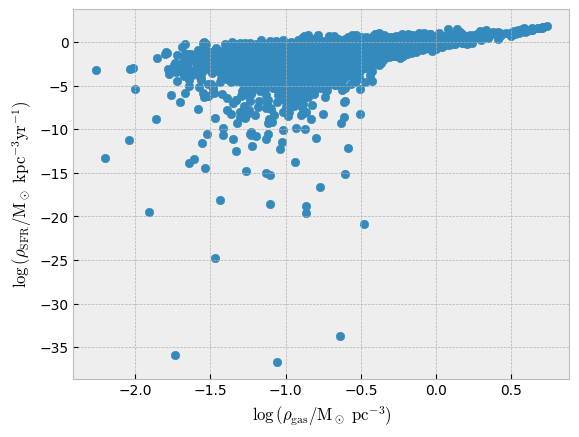

In [58]:
plt.scatter(np.log10(input_dict['midplane-dens']),
            np.log10(output_dict['midplane-SFR-dens']))
plt.xlabel(r'$\log{(\rho_{\rm gas}/{\rm M}_\odot~{\rm pc}^{-3})}$')
plt.ylabel(r'$\log{(\rho_{\rm SFR}/{\rm M}_\odot~{\rm kpc}^{-3}{\rm yr}^{-1})}$')
plt.show()

# check what the data looks like once standarized

In [59]:
def standarize_data(logX, logY):
    norm_dict = {
        'x_min': np.min(logX, axis=0),
        'y_min': np.min(logY, axis=0),
    }

    norm_dict['x_mean'] =  np.mean(logX, axis=0)
    norm_dict['x_std'] =  np.std(logX, axis=0)

    norm_dict['y_mean'] =  np.mean(logY, axis=0)
    norm_dict['y_std'] =  np.std(logY, axis=0)

    logX = (logX - norm_dict['x_mean']) / norm_dict['x_std']
    logY = (logY - norm_dict['y_mean']) / norm_dict['y_std']

    return logX, logY, norm_dict

In [60]:
X = np.stack([
    np.log10(feature) if key in log_features else feature for key, feature in input_dict.items()
], axis=1)
Y = np.stack([
    np.log10(feature) if key in log_features else feature for key, feature in output_dict.items()
], axis=1)

/tmp/ipykernel_100079/3025719563.py:2: RuntimeWarning: divide by zero encountered in log10
  np.log10(feature) if key in log_features else feature for key, feature in input_dict.items()


In [61]:
X, Y, norm_dict = standarize_data(X, Y)

/tmp/ipykernel_100079/941145492.py:13: RuntimeWarning: invalid value encountered in subtract
  logX = (logX - norm_dict['x_mean']) / norm_dict['x_std']


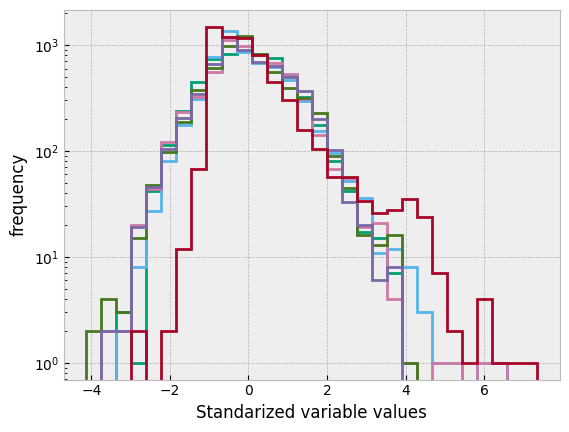

In [62]:
plt.hist(X, bins=30, histtype='step', lw=2, log=True)
plt.xlabel(r'Standarized variable values')
plt.ylabel(r'frequency')
plt.show()